In [84]:
# import optuna
# # import wandb
# import logging
# import sys
# import os
import tensorflow as tf
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, Bidirectional, MaxPooling1D, GlobalAveragePooling1D, AdditiveAttention, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import AdditiveAttention, Concatenate, BatchNormalization, Activation, MultiHeadAttention, LayerNormalization, TextVectorization, Masking, Reshape
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [85]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'new_df.csv')

X_df['y_liberal'] = y_df

In [86]:
print(X_df['without_stopwords'][1])
print(X_df['All_text'][1])

biden speech draw million usa tv viewer nan
Biden speech draws 38.2 million USA TV viewers nan


## Some preprocessing

In [87]:
# Assuming your DataFrame is named 'df' and the column you want to check is named 'column_name'
empty_rows = X_df['without_stopwords'].isnull()  # Check for empty values in the column

X_df = X_df.dropna(subset=['without_stopwords'])

# Define a function to replace the word "nan" with an empty string
def remove_nan(text):
    if isinstance(text, str):
        return text.replace('nan', '')
    return text

# Apply the function to the 'without_stopwords' column
X_df['without_stopwords'] = X_df['without_stopwords'].apply(remove_nan)

Text analysis for the whole dataset:
count    12804.000000
mean       169.314277
std        651.304189
min          2.000000
25%         39.000000
50%         57.000000
75%         91.000000
max      17886.000000
Name: length, dtype: float64

Analysis for class: 0
count     4514.000000
mean       148.880815
std        459.766989
min          2.000000
25%         38.000000
50%         57.000000
75%         88.000000
max      12799.000000
Name: length, dtype: float64
Top bigrams for class 0:
('free', 'market'): 113
('anarcho', 'capitalism'): 63
('minimum', 'wage'): 61
('joe', 'biden'): 56
('ron', 'desantis'): 48
('donald', 'trump'): 46
('elon', 'musk'): 45
('united', 'states'): 43
('anarcho', 'capitalist'): 43
('invasion', 'ukraine'): 42
('invade', 'ukraine'): 40
('russia', 'ukraine'): 39
('russian', 'invasion'): 39
('ronald', 'reagan'): 37
('truth', 'social'): 33
('thing', 'like'): 32
('state', 'union'): 31
('white', 'house'): 31
('supreme', 'court'): 31
('private', 'property'): 31




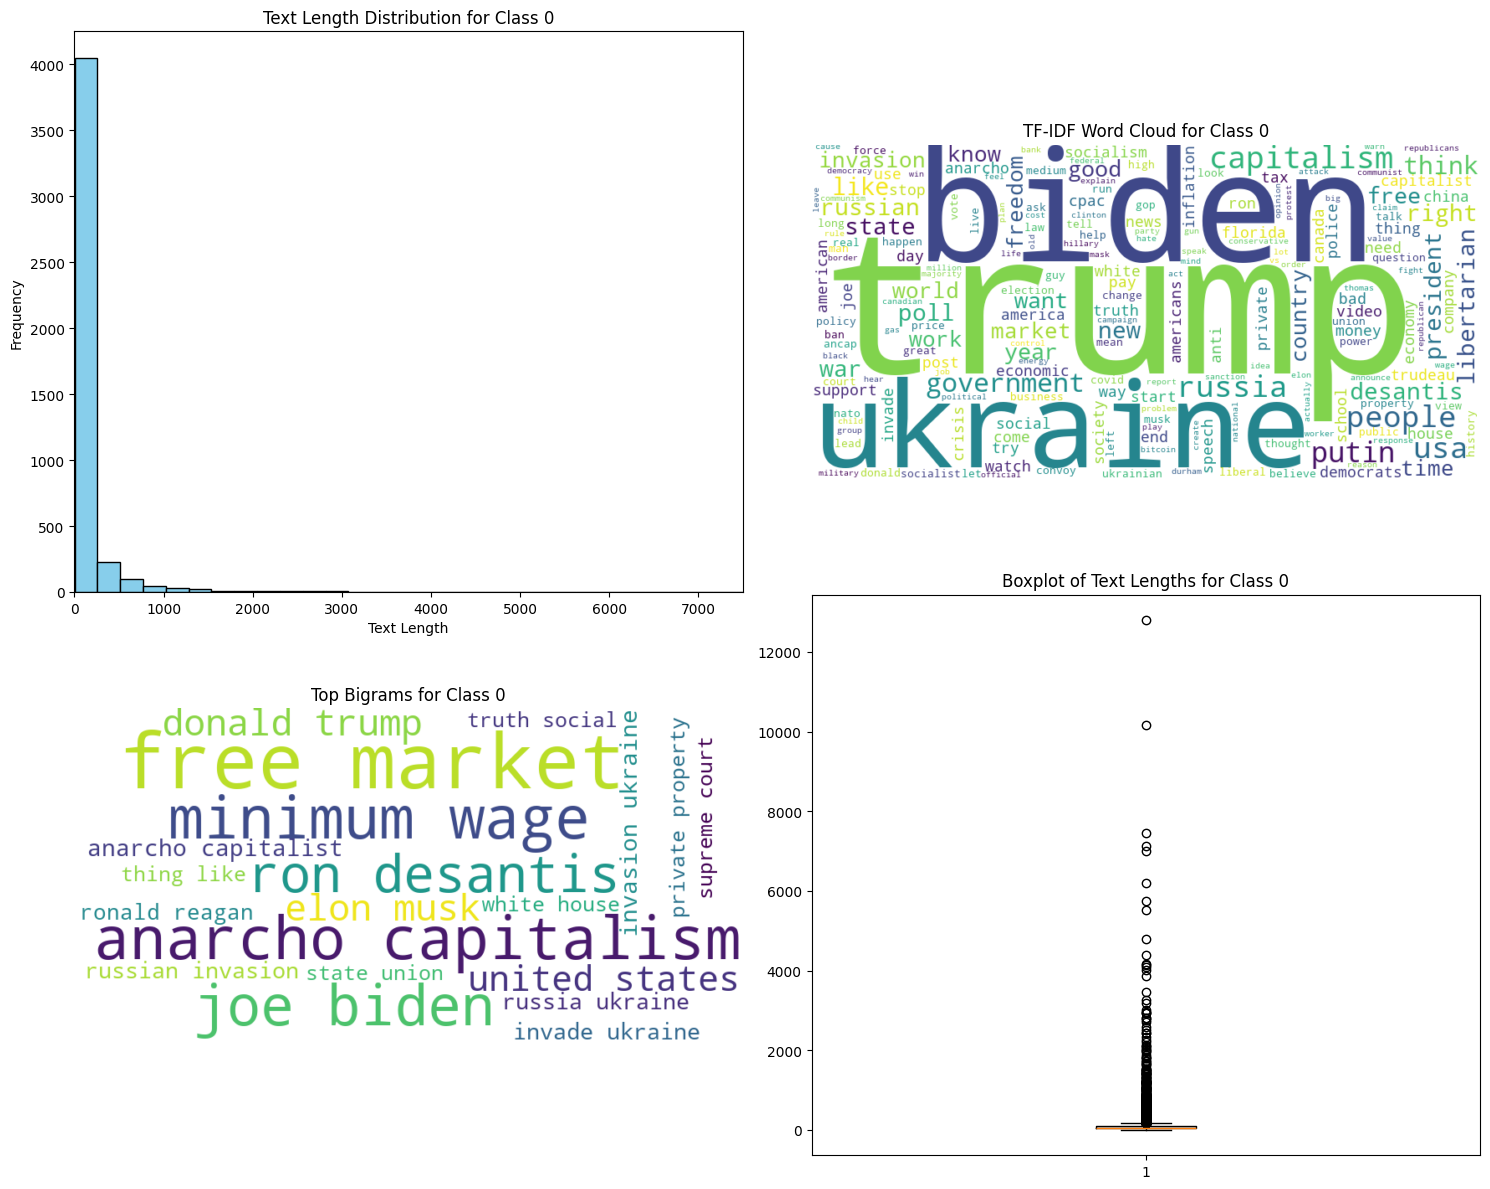


Analysis for class: 1
count     8290.000000
mean       180.440531
std        734.686140
min          3.000000
25%         39.000000
50%         57.000000
75%         92.000000
max      17886.000000
Name: length, dtype: float64
Top bigrams for class 1:
('social', 'democracy'): 225
('work', 'class'): 173
('social', 'democratic'): 125
('right', 'wing'): 120
('united', 'states'): 119
('supreme', 'court'): 105
('social', 'democrats'): 85
('feel', 'like'): 85
('democratic', 'party'): 84
('social', 'democrat'): 80
('minimum', 'wage'): 80
('white', 'house'): 78
('left', 'wing'): 76
('communist', 'party'): 74
('donald', 'trump'): 74
('soviet', 'union'): 73
('democratic', 'socialism'): 72
('new', 'york'): 71
('far', 'right'): 65
('look', 'like'): 63




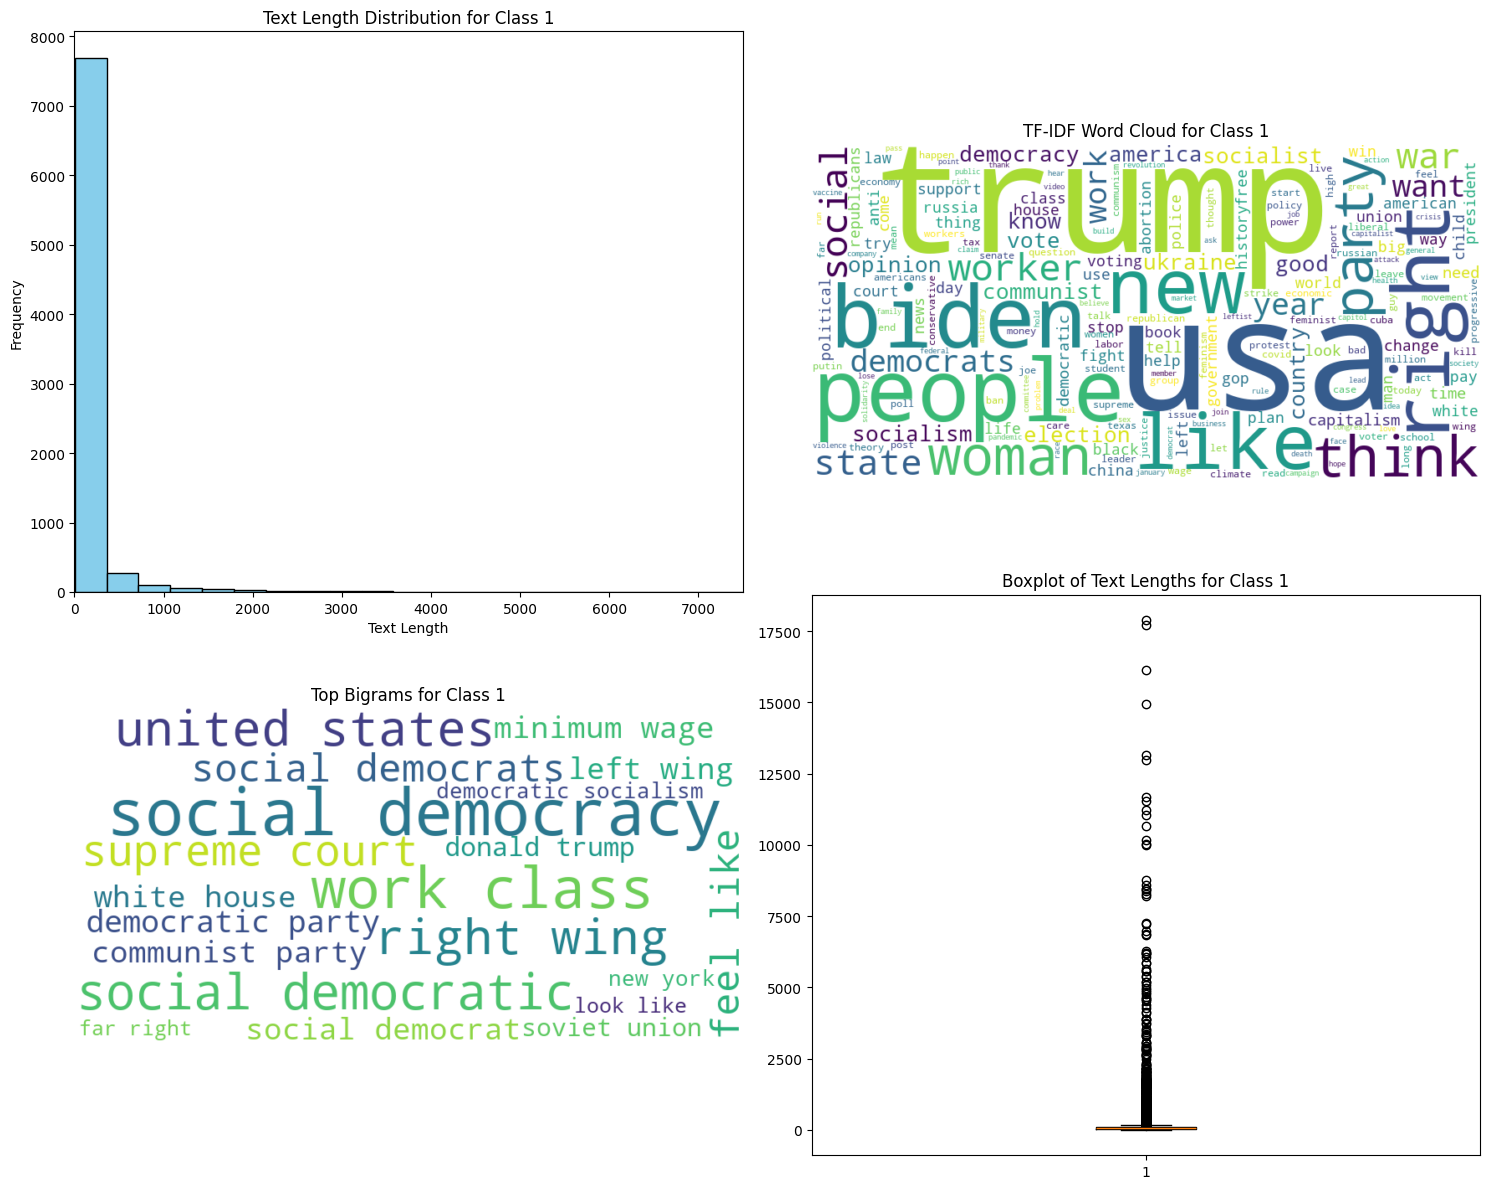

In [88]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from itertools import chain

# Download NLTK data files
# nltk.download('punkt')

# Assuming X_df is your DataFrame and 'without_stopwords' is the column you're interested in
# Calculate the length of each text entry in the 'without_stopwords' column
X_df['length'] = X_df['without_stopwords'].apply(lambda x: len(x))

# Print the DataFrame with the added 'length' column
print('Text analysis for the whole dataset:')
print(X_df['length'].describe())

# Group by the target variable 'y_liberal'
groups = X_df.groupby('y_liberal')

# Define a function to extract and count bigrams
def get_top_bigrams(texts, top_n=20):
    tokens = chain(*[word_tokenize(text.lower()) for text in texts])
    bigrams = list(nltk.bigrams(tokens))
    bigram_freq = FreqDist(bigrams)
    return bigram_freq.most_common(top_n)

# Perform analyses and visualizations for each class label
for name, group in groups:
    print(f"\nAnalysis for class: {name}")
    
    # Descriptive statistics for text length
    print(group['length'].describe())
    
    # Prepare subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Visualize text length distribution
    axs[0, 0].hist(group['length'], bins=50, color='skyblue', edgecolor='black')
    axs[0, 0].set_title(f'Text Length Distribution for Class {name}')
    axs[0, 0].set_xlabel('Text Length')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].set_xlim(0, 7500)  # Set x-axis limit
    
    # Generate TF-IDF word cloud
    text = group['without_stopwords'].tolist()
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(text)
    tfidf_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    axs[0, 1].imshow(wordcloud, interpolation='bilinear')
    axs[0, 1].axis('off')
    axs[0, 1].set_title(f'TF-IDF Word Cloud for Class {name}')
    
    # Calculate top bigrams
    top_bigrams = get_top_bigrams(group['without_stopwords'])
    print(f"Top bigrams for class {name}:")
    for bigram, freq in top_bigrams:
        print(f"{bigram}: {freq}")
    print("\n")
    
    # Visualize top bigrams for each class
    bigram_dict = {f'{bigram[0]} {bigram[1]}': freq for bigram, freq in top_bigrams}
    bigram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_dict)
    axs[1, 0].imshow(bigram_wordcloud, interpolation='bilinear')
    axs[1, 0].axis('off')
    axs[1, 0].set_title(f'Top Bigrams for Class {name}')
    
    # Identify and visualize outliers in text length
    axs[1, 1].boxplot(group['length'])
    axs[1, 1].set_title(f'Boxplot of Text Lengths for Class {name}')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [89]:
# Konverter kolonnen til et NumPy array
X = X_df['without_stopwords'].astype(str).to_numpy().flatten()
y = X_df['y_liberal'].to_numpy()

tokenizer = Tokenizer(oov_token='<OOV>') # Hyperparameters = num_words=vocab_size, oov_token=oov_tok
tokenizer.fit_on_texts(X)

#Creating a word index of the words from the tokenizer 
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.\n\nFirst 10 is listen below:')
print(dict(list(word_index.items())[0:10]))

Found 22336 unique tokens.

First 10 is listen below:
{'<OOV>': 1, 'people': 2, 'usa': 3, 'like': 4, 'work': 5, 'right': 6, 'trump': 7, 'think': 8, 'state': 9, 'government': 10}


## Setting hyperparameters

In [90]:
# Defining pre-processing hyperparameters for the networks
max_len = 150
trunc_type = "post"
padding_type = "post"
vocab_size = len(word_index)
embedding_dim = 100
EPOCHS=20
BATCH_SIZE = 32
num_classes = 1

## Create datasets

In [91]:
# y_list = np.array([[element] for element in y])
# y_list

In [92]:
# Encoding the sequences from the reddit posts
X = tokenizer.texts_to_sequences(X)
# Padding the sequences to keep the lengths uniform
X = pad_sequences(X, maxlen=max_len, padding=padding_type, truncating=trunc_type)
# print('Shape of data tensor:', X_tensorflow.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)#, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)#, stratify=y_test)

## Batch the data

In [93]:
class ModelConfig:
    def __init__(self, max_len, num_classes, embeddings_GloVe):
        self.max_len = max_len
        self.num_classes = num_classes
        self.embeddings_GloVe = embeddings_GloVe


# Create a configuration object
config = ModelConfig(max_len=max_len, num_classes=num_classes, embeddings_GloVe=embeddings_GloVe)

with open(r'C:\Users\bugat\GIT\Tekstanalyse\git_NLP_Notebooks\best_trial_length_100.json', 'r') as f:
    trial = json.load(f)
    params = trial['params']

In [109]:
def CNN_LSTM_sequential(params, config):
    input = Input(shape=(config.max_len,), dtype='int32')
    
    # Use config object for fixed parameters such as embeddings
    embedding = Embedding(input_dim=config.embeddings_GloVe.shape[0],
                          output_dim=config.embeddings_GloVe.shape[1],
                          weights=[config.embeddings_GloVe],
                          trainable=False)(input)
    
    # Use params dictionary for dynamic hyperparameters
    dropout = Dropout(params['dropout_rate'])(embedding)

    conv = Conv1D(filters=params['conv_filters'], kernel_size=1, activation='relu')(dropout)
    conv = BatchNormalization()(conv)

    lstm = Bidirectional(LSTM(params['lstm_units'], return_sequences=False, dropout=0.006, recurrent_dropout=0.1))(conv)
    lstm = LayerNormalization()(lstm)
    
    # num_heads = 8
    # attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=config.embeddings_GloVe.shape[1] // num_heads, dropout=0.1)
    # attention_output = attention_layer(query=lstm, key=lstm, value=lstm)
    # attention_output = LayerNormalization()(attention_output)

    dense = Dense(params['dense_2_units'], activation='relu')(lstm)#(attention_output)
    dense = BatchNormalization()(dense)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=Adam(params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Set the bias

In [95]:
num_ones = np.count_nonzero(y)
num_zeros = y.size - num_ones
initial_bias = np.log(num_ones) / (num_zeros)
print("Initial bias:", initial_bias)

Initial bias: 0.0019988491909901066


In [96]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

def simple_CNN_model(params, config):
    
    # Define input
    input = Input(shape=(max_len,), dtype=tf.int32)
    
    # Embedding Layer
    embedding_layer = Embedding(input_dim=config.embeddings_GloVe.shape[0],
                                output_dim=config.embeddings_GloVe.shape[1],
                                weights=[embeddings_GloVe],
                                trainable=False)
    
    embedded_seq = embedding_layer(input)

    # # Masking Layer
    # masked_input = Masking(mask_value=0.0)(embedded_seq)
    
    # # CNN Branch
    # reshaped_input = Reshape((max_len, embeddings_GloVe.shape[1]))(masked_input)
    
    # CNN Branch
    # reshaped_input = Reshape((max_len, embeddings_GloVe.shape[1]))(embedded_seq)
    dropout_cnn = Dropout(params['dropout_rate'])(embedded_seq)
    batch = BatchNormalization()(dropout_cnn)
    cnn = Conv1D(params['conv_filters'], 3, activation='relu')(batch)
    dropout_cnn = Dropout(0.2)(cnn)
    cnn = BatchNormalization()(dropout_cnn)
    cnn = Flatten()(cnn)

    # Dense Layer
    dense = Dense(params['dense_2_units'], activation='relu')(cnn)
    dropout_final = Dropout(0.2)(dense)

    # Output layer
    output = Dense(1, activation='sigmoid', 
                   bias_initializer=tf.keras.initializers.Constant(0.002))(dropout_final)

    # Build the model
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), 
                  loss=focal_loss, 
                  metrics=['accuracy'])

    return model

In [106]:
focal_loss = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,  # Adjusted for class imbalance
    alpha=0.15,                  # Default alpha, consider increasing if imbalance is high
    gamma=1.5,                   # Default gamma, adjust based on experimentation
    from_logits=False,           # Ensure this matches your model's output type
    label_smoothing=0.4,         # Apply a small amount of label smoothing to help with overfitting
    axis=-1,                     # Default, typically correct for most datasets
    reduction='sum_over_batch_size',  # Default, consider 'auto' or 'none' for different scenarios
    name='binary_focal_crossentropy'
)

In [110]:
model = CNN_LSTM_sequential(params, config)

In [111]:
# Compile and train the model
model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=20,
          batch_size= 32, 
          verbose=1)

Epoch 1/20
141/281 [==============>...............] - ETA: 1:39 - loss: 0.7172 - accuracy: 0.5895

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [ ]:
# Assuming you have X_test as your features for the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.50).astype("int32")  # Thresholding probabilities to get binary class labels

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

print("Precision for Class 0: {:.2f}".format(precision[0]))
print("Precision for Class 1: {:.2f}".format(precision[1]))
print("Recall for Class 0: {:.2f}".format(recall[0]))
print("Recall for Class 1: {:.2f}".format(recall[1]))

61/61 [==============================] - 1s 5ms/step
Confusion Matrix:
[[  59  618]
 [  41 1203]]
Precision for Class 0: 0.59
Precision for Class 1: 0.66
Recall for Class 0: 0.09
Recall for Class 1: 0.97


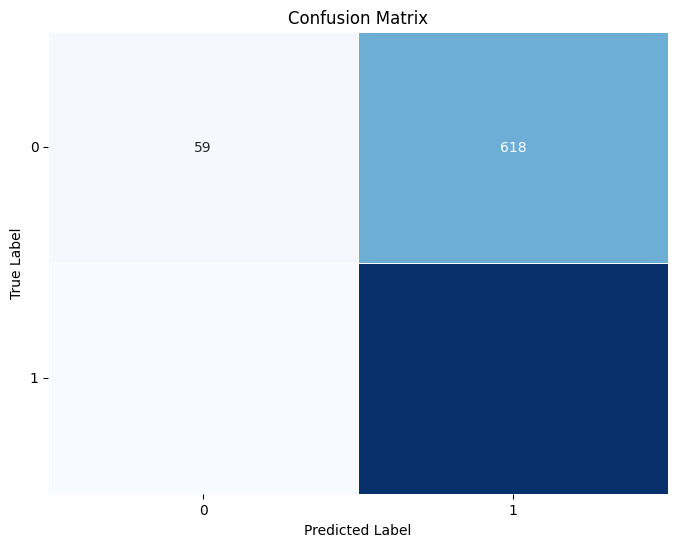

In [ ]:
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['0', '1'])  # Adjust ticks to center under 0 and 1 if necessary
plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)
plt.show()